<a href="https://colab.research.google.com/github/OrianaMart/ECEN-403---Team-39/blob/ML/TEAM39_MLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Author: Oriana V Martin
#UIN: 527008754
#Date: October 18, 2023
#Description: The ML model's role is to analyze images of laboratory equipment and assign appropriate labels or categories.
#By utilizing a linked image dataset, the model can provide users with real-time information regarding equipment categorization.
#In the training process, a dataset will be generated, and a validation dataset will be established to evaluate the model's accuracy.

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

#once this is run, there should be an error 'Failure("Error opening URL:' click on the link to authorize a new account
#after authroization is completed, run the next cell



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

#in this cell, there ahould be an output of 'Access token retrieved correctly.' to have successfully mounted the other drive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 120900 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.1) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
#This section is where all the necessary imports are brought into the project
import tensorflow as tf    #Import Tensorflow a machine learning library
import matplotlib.pyplot as plt #Import Matplotlib a library to create plots and data visualization
print(tf.__version__)

2.13.0


In [ ]:
seed_train_validation = 1337 # Must be same for train_ds and val_ds
shuffle_value = True #image_dataset_from_directory is taking the end portion of the dataset as the validation split. shuffle is now set to True, so the dataset is shuffled before training, to avoid using only some classes for the validation split.
validation_split = 0.3 #percentage of dataset to be considered for validation
img_height, img_width = 180,180
image_size = (img_height, img_width) #input image size is set to 180x180
batch_size = 32 #Set the batch size for data preprocessing, this value may be changed according to the amount of input data

train_ds = tf.keras.utils.image_dataset_from_directory(
directory ='/content/drive/MyDrive/DatasetV5',
image_size = image_size, #shape/size of the input images
validation_split = validation_split, #30%
subset = "training", #this creates a training subset
seed = seed_train_validation, #seed is set so that the results are reproduced, must match for all datasets
color_mode = 'rgb', #images are converted into 3 color channels
shuffle = shuffle_value,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory ='/content/drive/MyDrive/DatasetV5',
image_size = image_size, #shape/size of the input images
validation_split = validation_split, #30%
subset = "validation", #this creates a validation subset
seed = seed_train_validation, #seed is set so that the results are reproduced, must match for all datasets
color_mode = 'rgb', #images are converted into 3 color channels
shuffle = shuffle_value,
)


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds) #determines how many batches are within the created validation dataset
test_ds = val_ds.take((2*val_batches) // 3) #move two-thirds of images (2/3 of 30% = 20%) to a test dataset
val_ds = val_ds.skip((2*val_batches) // 3) #keep the remaining images as the validation dataset

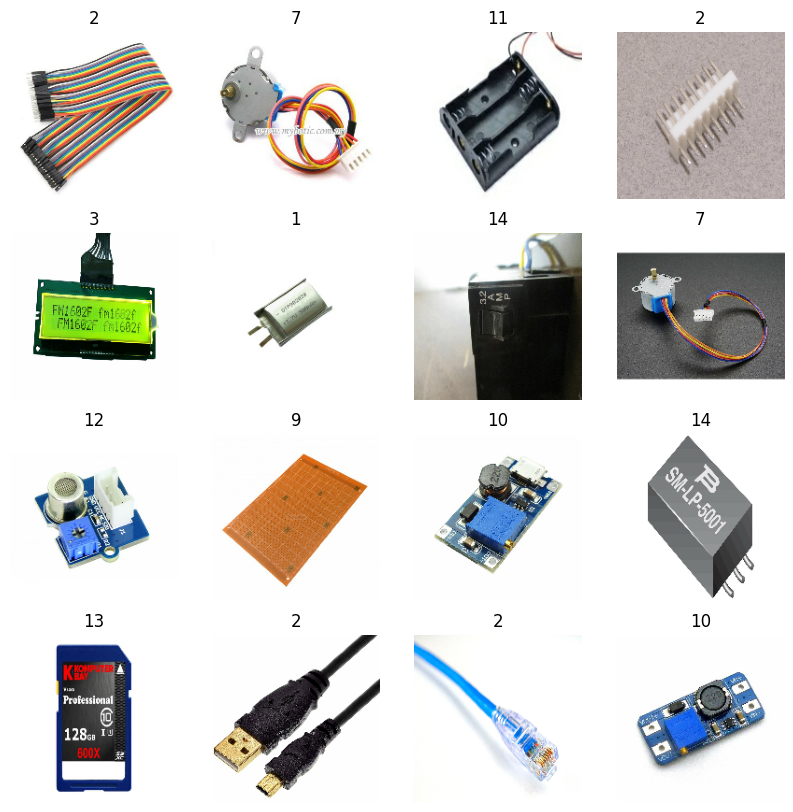

In [ ]:
#define a list of class names, which will represent the labels for the data
class_names = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#examples of the class names as strings
#class_names = ["Battery", "Connector", "Display", "Fan/Heatsink", "Line/Gate Driver", "MCU Dev Board", "Motor", "Motor Driver", "Perf/Proto Board", "Power DC-DC", "Power Supply", "Sensor", "Storage Device", "Transformer"]
plt.figure(figsize=(10,10)) #creates a figure for plotting images with their labels

#iterate over a batch of data in the training dataset
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1) #this creates a subplot for each image
    plt.imshow(images[i].numpy().astype("uint8")) #this displays the image
    plt.title(class_names[labels[i]]) #sets subplot titles as the corresponding class name
    plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential( #This is the primary preprocessing done to the image dataset
  [
    tf.keras.layers.RandomFlip("horizontal"), #This layer randomly flips images horizontally during training
    tf.keras.layers.RandomRotation(0.1), #This layer randomly rotates images during training
    tf.keras.layers.RandomZoom(0.1), #This layer randomly zooms images horizontally during training
    tf.keras.layers.RandomBrightness(0.2), #This layer randomly changes the brightness of images horizontally during training, this is done to help train for more lighting scenarios
    tf.keras.layers.RandomContrast(0.2) #This layer randomly changes the contrast of images horizontally during training,  this is done to help train for more lighting scenarios
  ]
)

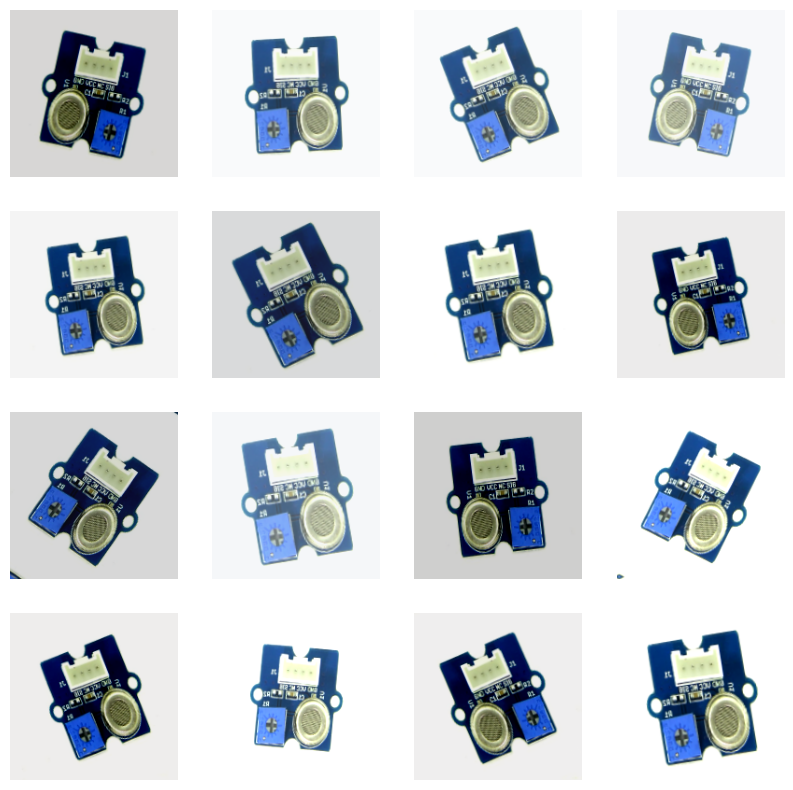

In [ ]:
plt.figure(figsize=(10, 10))  #creates a figure that plots augtmented images with a specified size

#iterate over a batch of data in the training dataset
for images, labels in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images) #applies the data augmentation to the batch
    ax = plt.subplot(4, 4, i + 1) #creates a subplot for each of the images
    plt.imshow(augmented_images[0].numpy().astype("uint8")) #displays the images as a NumPy array
    plt.axis("off") #no axis labels or ticks in the subplots

In [ ]:
# Apply `data_augmentation` to the training images.
#enchances training by generating variations of the images
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
#loads data in the background to reduce the GPU idle time, this time is mostly taken up by data loading and preprocessing
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

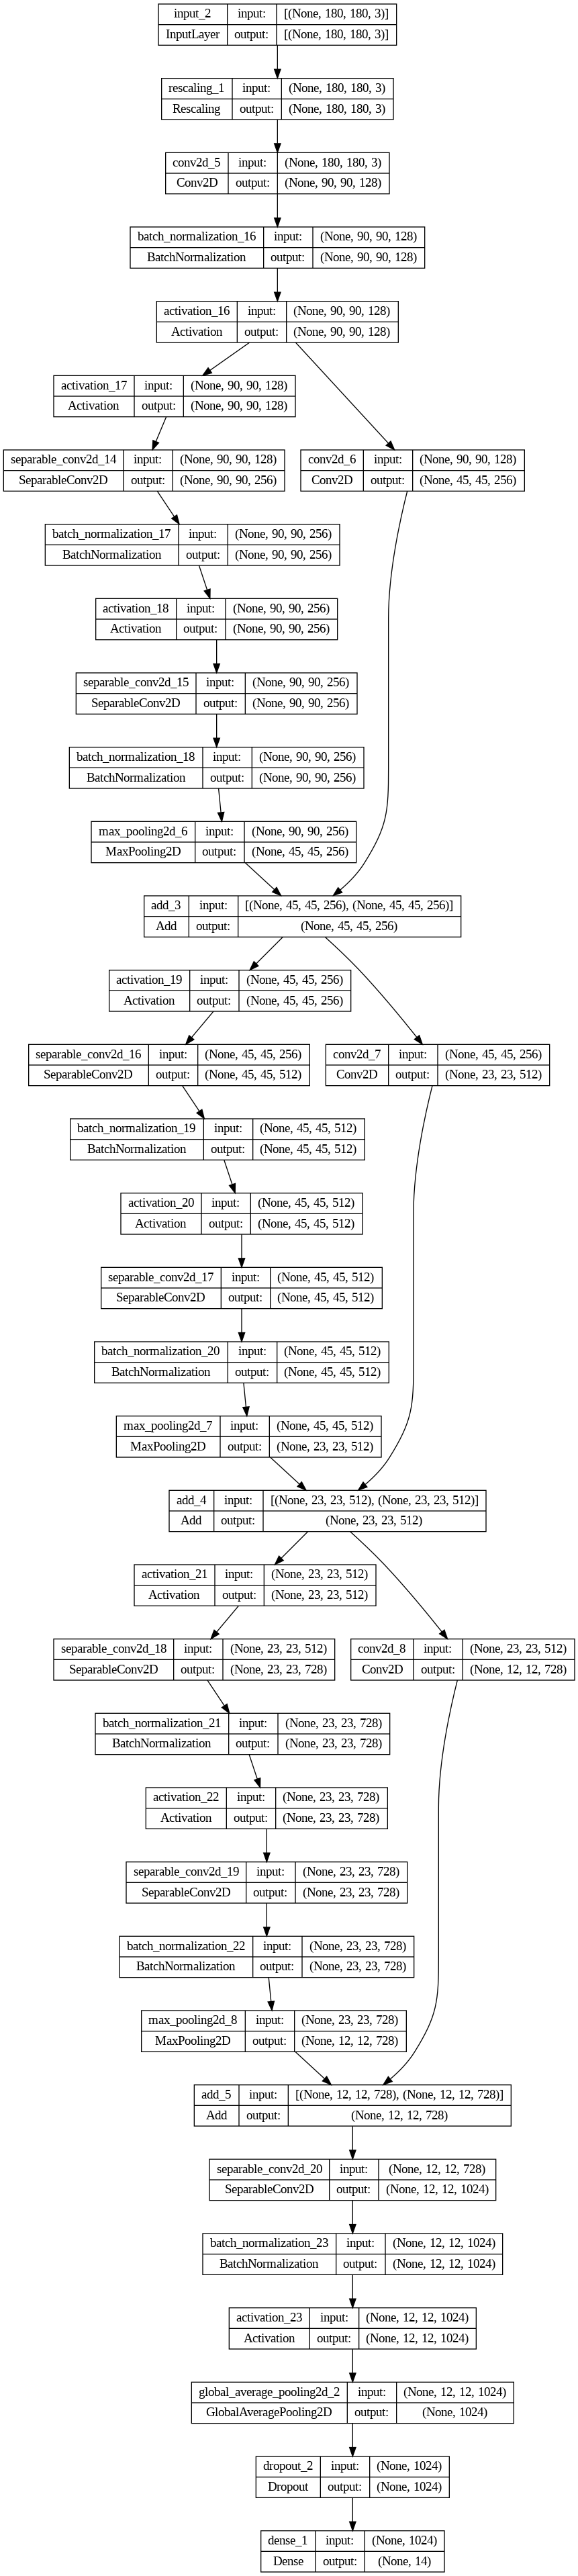

In [ ]:
#define a function to create a convolutional neural network (CNN) model
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape) #input layer with the given shape

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs) #normalizes the inputs data to a range of 0 and 1 by dividing the pixels by 255
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(x) #convolutional layer, extracts features from the input images
    x = tf.keras.layers.BatchNormalization()(x) #batch normailzation, normalizes the activations to stabilize and speed up training
    x = tf.keras.layers.Activation("relu")(x) #relu activation, replaces all negative values in the input with 0, helps the model learn more complex patterns (rectified linear unit activation)

    previous_block_activation = x  # Set aside residual, which are the differences between observed and predicted values of data

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x) #relu activation
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x) #seperable convolution, breaksdown the covolution into depthwise and pointwise. reduces number of computations, but keeps ability to capture features
        x = tf.keras.layers.BatchNormalization()(x) #batch normalization

        x = tf.keras.layers.Activation("relu")(x) #relu activation
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x) #seperable convolution
        x = tf.keras.layers.BatchNormalization()(x) #batch normalization

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x) #max pooling, reduces the spatial dimension of the feature maps, reduces the spatial resolution while keeping the most important features

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x) #seperable convolution
    x = tf.keras.layers.BatchNormalization()(x) #batch normalization
    x = tf.keras.layers.Activation("relu")(x) #relu activation

    x = tf.keras.layers.GlobalAveragePooling2D()(x) #global average pooling, computes the average of each feature map, resulting in a single value for each feature map
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.1)(x) #dropout for regularization, some number of layer outputs are randomly ignored or "dropped out"
    outputs = tf.keras.layers.Dense(units, activation=activation)(x) #output layer
    return tf.keras.Model(inputs, outputs)

#creates a model using the defined function
model = make_model(input_shape=image_size + (3,), num_classes=14)
#plots the achitecture with shapes
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#define a constant for the dataset optimization
AUTOTUNE = tf.data.AUTOTUNE

#applies the dataset optimizations to the training and validation  datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
#displays a summary of the model's architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 90, 90, 128)          3584      ['rescaling_1[0][0]']         
                                                                                                  
 batch_normalization_16 (Ba  (None, 90, 90, 128)          512       ['conv2d_5[0][0]']            
 tchNormalization)                                                                          

In [ ]:
#defines a ModelCheckpoint to callback to save the model's weights at each epoch
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]

#compiles the model with a specified optimizer, loss function and evaluation metric
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2), #defines the optimizer with a specific learning rate
    loss = tf.losses.SparseCategoricalCrossentropy(), #defines the loss function for training, computes the crossentropy loss between the labels and predictions
    metrics=["accuracy"] #specifies the evaluation metric to track during training
)

In [ ]:
#train the model and store the training history
history = model.fit(
    train_ds, #the training dataset
    validation_data = val_ds, #the validation dataset
    callbacks = callbacks, #list of the callbacks (model checkpointing)
    epochs = 25 #number of training epochs
)

In [ ]:
model.evaluate(test_ds) #evaluates the model using the test dataset

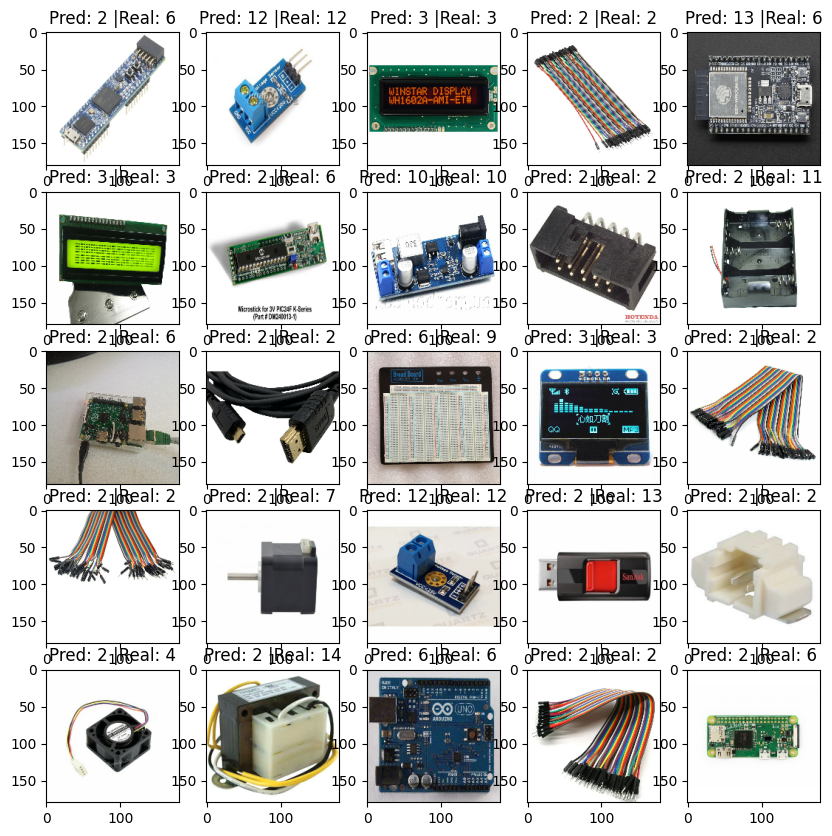

In [ ]:
#import the required libraries
import numpy

plt.figure(figsize = (10,10)) #creates a figure for plotting with a set size
for images, labels in test_ds.take(1): #loops through a batch of test images and their labels
  classifications = model(images) #makes predictions using the model
  #print(classifications)

  for i in range(25):
    ax = plt.subplot(5, 5, i+1) #creates subplots for a 5x5 grid
    plt.imshow(images[i].numpy().astype("uint8")) #displays the test image
    index = numpy.argmax(classifications[i]) #gets the index of the highest prediction value
    plt.title("Pred: " + str(class_names[index]) + " |Real: " + str(class_names[labels[i]])) #sets the title to include the predicted and real class names

In [ ]:
#extract training and validation accuracy as well as loss from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#defines the number os epochs and creates a range using the value
epochs = 25
epochs_range = range(epochs)

#creates a figure with two subplots
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

#plots training and validation accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

#plots training and validation loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

#displays the figure
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools  # Add this line to import itertools

#true labels (ground truth) and predicted labels
y_true = np.array([1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,8,9,9,9,9,10,10,10,10,10,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12,12,13,13,13,13,14,14,14,14,14])
y_pred = np.array([2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,2,2,2,5,5,2,2,6,6,13,2,6,2,13,2,2,6,2,2,2,2,2,2,2,2,2,13,9,14,9,6,2,2,10,10,10,2,2,2,2,11,2,2,12,12,2,2,12,12,12,12,2,12,12,12,2,13,13,2,2,2,14,13,2])

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create a figure and axis for plotting
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Labels for the matrix
classes = ["Battery", "Connector", "Display", "Fan/Heatsink", "Line/Gate Driver", "MCU Dev Board", "Motor", "Motor Driver", "Perf/Proto Board", "Power DC-DC", "Power Supply", "Sensor", "Storage Device", "Transformer"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Fill the cells with numbers
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show the plot
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) #convert neural network into TF Lite model
tflite_model = converter.convert() #converts model into the proper TF Lite file type

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)  #Write the saved TF lite model into a new file

In [ ]:
#download the converted model file to local system
from google.colab import files
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>